# Example 3: Pandapipes

This Example demonstrates how to generate a pandapipes network based on a SIR 3S model. When working with SIR 3S, pandapipes used to offer some freedom in creating simple DH models via Python, but with the introduction of the SIR 3S Toolkit, pandapipes is no longer necessary for this. Therefore the main benefit of pandapipes for SIR 3S users is for comparing calculations to SIR 3S results. 

Note that the SIR 3S model we are using in this Example is quite simple.

In this Example we will first generate the pandapipes network manually by obtaining element dataframes for pipes and nodes via SIR 3S Toolkit. Then we will perform the same steps but built into one single Toolkit function.

# Toolkit Release

In [43]:
#pip install 

# Imports

## SIR 3S Toolkit

### Regular Import/Init

In [44]:
SIR3S_SIRGRAF_DIR = r"C:\3S\SIR 3S Entwicklung\SirGraf-90-15-00-16_Quebec_x64" #change to local path

In [45]:
import sir3stoolkit

In [46]:
from sir3stoolkit.core import wrapper

In [47]:
sir3stoolkit

<module 'sir3stoolkit' from 'C:\\Users\\aUsername\\3S\\sir3stoolkit\\src\\sir3stoolkit\\__init__.py'>

In [48]:
wrapper.Initialize_Toolkit(SIR3S_SIRGRAF_DIR)

### Additional Import/Init for Alternative_Models class

In [49]:
from sir3stoolkit.mantle import alternative_models

In [50]:
s3s = alternative_models.Alternative_Models_SIR3S_Model()

Initialization complete


## Additional

In [51]:
import pandas as pd

In [52]:
import pandapipes as pp

In [53]:
from shapely import wkt

In [54]:
import pandapipes.plotting as pp_plot

# Open SIR 3S Model

In [55]:
s3s.OpenModel(dbName=r"C:\Users\aUsername\3S\PT3S\PT3S\Examples\Example9_2.db3",
              providerType=s3s.ProviderTypes.SQLite,
              Mid="M-1-0-1",
              saveCurrentlyOpenModel=False,
              namedInstance="",
              userID="",
              password="")

Model is open for further operation


# Generate Pandapipes network manually

## Create pandapipes network

### Nodes

In [56]:
net = pp.create_empty_network(fluid="water")

In [57]:
df_nodes_metadata = s3s.generate_element_metadata_dataframe(s3s.ObjectTypes.Node, ['Name', 'QmEin', 'bz.PhEin', 'Zkor', 'Ktyp'], geometry=True)

[2025-10-07 13:27:29,772] INFO in sir3stoolkit.mantle.dataframes: [metadata] Generating metadata dataframe for element type: ObjectTypes.Node
[2025-10-07 13:27:29,773] INFO in sir3stoolkit.mantle.dataframes: [metadata] Retrieved 9 element(s) of element type ObjectTypes.Node.
[2025-10-07 13:27:29,776] DEBUG in sir3stoolkit.mantle.dataframes: [Resolving Metadata Properties] Using 5 metadata properties.
[2025-10-07 13:27:29,777] INFO in sir3stoolkit.mantle.dataframes: [metadata] Retrieving metadata properties ['Name', 'QmEin', 'bz.PhEin', 'Zkor', 'Ktyp'], geometry...
[2025-10-07 13:27:29,777] INFO in sir3stoolkit.mantle.dataframes: [metadata] 0 non-empty end node columns were created)
[2025-10-07 13:27:29,783] INFO in sir3stoolkit.mantle.dataframes: [metadata] Done. Shape: (9, 7)


In [58]:
df_nodes_results = s3s.generate_element_results_dataframe(s3s.ObjectTypes.Node, ['PH', 'T', 'QM'], s3s.GetTimeStamps()[0])

[2025-10-07 13:27:29,803] INFO in sir3stoolkit.mantle.dataframes: [results] Generating results dataframe for element type: ObjectTypes.Node
[2025-10-07 13:27:29,812] INFO in sir3stoolkit.mantle.dataframes: [Resolving Timestamps] Only static timestamp 2025-06-05 15:27:46.000 +02:00 is available
[2025-10-07 13:27:29,813] INFO in sir3stoolkit.mantle.dataframes: [results] Retrieved 9 tks.
[2025-10-07 13:27:29,816] INFO in sir3stoolkit.mantle.dataframes: [results] Using 3 result properties.
[2025-10-07 13:27:29,816] INFO in sir3stoolkit.mantle.dataframes: [results] Retrieving result properties...
[2025-10-07 13:27:29,820] INFO in sir3stoolkit.mantle.dataframes: [results] Done. Shape: (9, 5)


In [59]:
df_nodes = pd.merge(df_nodes_metadata, df_nodes_results, on='tk', how='inner')

In [60]:
df_nodes.head(3)

,tk,Name,QmEin,bz.PhEin,Zkor,Ktyp,geometry,timestamp,PH,T,QM
0,5136506604482101815,K0000,0,100,10,PKON,POINT (149.99985694885254 500.00011920928955),2025-06-05 15:27:46.000 +02:00,100,0,400
1,5174640379525019821,K0001,0,0,10,QKON,POINT (349.99996423721313 600.00002384185791),2025-06-05 15:27:46.000 +02:00,99.99306,0,0
2,5665004361761998834,K0002,0,0,10,QKON,POINT (550.00007152557373 600.00002384185791),2025-06-05 15:27:46.000 +02:00,99.86531,0,0


In [61]:
js = {}

for idx, row in df_nodes.iterrows():
    geom = wkt.loads(row["geometry"])
    x, y = geom.x, geom.y

    j = pp.create_junction(
        net,
        pn_bar=1 + float(row['PH']),
        tfluid_k=273.15 + float(row['T']),
        height_m=float(row['Zkor']),
        name=f"{row['Name']}~{row['tk']}"
    )

    # Assign geodata to junction_geodata table
    net.junction_geodata.at[j, "x"] = x
    net.junction_geodata.at[j, "y"] = y

    js[row['tk']] = j

In [62]:
net.junction

,name,pn_bar,tfluid_k,height_m,in_service,type
0,K0000~5136506604482101815,101.00000,273.15,10.0,True,junction
1,K0001~5174640379525019821,100.99306,273.15,10.0,True,junction
2,K0002~5665004361761998834,100.86531,273.15,10.0,True,junction
3,K0003~5185493728872360834,100.72040,273.15,10.0,True,junction
4,K0004~4776931467066465913,100.72040,273.15,10.0,True,junction
5,K0005~5229509832448527475,100.93705,273.15,10.0,True,junction
6,K0006~5073490478136313655,100.87409,273.15,10.0,True,junction
7,K0007~5417314986988666587,100.86626,273.15,10.0,True,junction
8,K0008~5366461594623940805,100.86626,273.15,10.0,True,junction


### pipes

In [63]:
df_pipes_metadata = s3s.generate_element_metadata_dataframe(s3s.ObjectTypes.Pipe, ['L', 'Di', 'Rau', 'Name'], end_nodes=True, geometry=True)

[2025-10-07 13:27:29,918] INFO in sir3stoolkit.mantle.dataframes: [metadata] Generating metadata dataframe for element type: ObjectTypes.Pipe
[2025-10-07 13:27:29,919] INFO in sir3stoolkit.mantle.dataframes: [metadata] Retrieved 9 element(s) of element type ObjectTypes.Pipe.
[2025-10-07 13:27:29,921] DEBUG in sir3stoolkit.mantle.dataframes: [Resolving Metadata Properties] Using 4 metadata properties.
[2025-10-07 13:27:29,922] INFO in sir3stoolkit.mantle.dataframes: [metadata] Retrieving metadata properties ['L', 'Di', 'Rau', 'Name'], geometry, end nodes...
[2025-10-07 13:27:29,927] INFO in sir3stoolkit.mantle.dataframes: [metadata] 2 non-empty end node columns were created)
[2025-10-07 13:27:29,927] INFO in sir3stoolkit.mantle.dataframes: [metadata] Done. Shape: (9, 8)


In [64]:
for idx,row in df_pipes_metadata.iterrows():
    raw_value = row["Rau"]
    row["Rau"] = float(str(raw_value).replace(",", "."))

In [65]:
df_pipes_metadata.head(3)

,tk,L,Di,Rau,Name,geometry,fkKI,fkKK
0,4762947358005495341,1000,450,0.25,Rohr K0000 K0001,LINESTRING (149.99985694885254 500.00011920928...,5136506604482101815,5174640379525019821
1,5479123649362439650,1000,250,0.25,Rohr K0002 K0003,LINESTRING (550.00007152557373 600.00002384185...,5665004361761998834,5185493728872360834
2,5367303884852200682,1000,250,0.25,Rohr K0002 K0004,LINESTRING (550.00007152557373 600.00002384185...,5665004361761998834,4776931467066465913


In [66]:
ps = {}

for idx, row in df_pipes_metadata.iterrows():
    geom = wkt.loads(row["geometry"])  
    coords = list(geom.coords)        

    # Create pipe
    p = pp.create_pipe_from_parameters(
        net,
        from_junction=js[row['fkKI']],
        to_junction=js[row['fkKK']],
        length_km=float(row['L']) / 1000.,
        diameter_m=float(row['Di']) / 1000.,
        k_mm=float(row['Rau']),
        name=f"{row['Name']}~{row['tk']}"
    )
    ps[row['tk']] = p

    net.pipe_geodata.at[p, "coords"] = coords

In [67]:
net.pipe.head(3)

,name,from_junction,to_junction,std_type,length_km,diameter_m,k_mm,loss_coefficient,u_w_per_m2k,text_k,qext_w,sections,in_service,type
0,Rohr K0000 K0001~4762947358005495341,0,1,None,1.0,0.45,0.25,0.0,0.0,NaN,0.0,1,True,pipe
1,Rohr K0002 K0003~5479123649362439650,2,3,None,1.0,0.25,0.25,0.0,0.0,NaN,0.0,1,True,pipe
2,Rohr K0002 K0004~5367303884852200682,2,4,None,1.0,0.25,0.25,0.0,0.0,NaN,0.0,1,True,pipe


### sources/sinks

In [68]:
for idx, row in df_nodes.iterrows():
    ktyp = (row.get("Ktyp"))
    tk = row.get("tk")

    # Create source if Ktyp is PKON and PH > 0
    if ktyp == "PKON" and float(row.get("PH", 0)) > 0:
        pp.create_ext_grid(
            net,
            junction=js[tk],
            p_bar=1 + float(row["PH"]),
            t_k=273.15 + float(row["T"]),
            name=f"Src: {row['Name']}~{tk}"
        )

    # Create sink if Ktyp is QKON and QM < 0
    elif ktyp == "QKON" and float(row.get("QM", 0)) < 0:
        pp.create_sink(
            net,
            junction=js[tk],
            mdot_kg_per_s=abs(float(row["QM"])),
            name=f"Snk: {row['Name']}~{tk}"
        )

In [69]:
net.ext_grid

,name,junction,p_bar,t_k,in_service,type
0,Src: K0000~5136506604482101815,0,101.0,273.15,True,pt


In [70]:
net.sink

,name,junction,mdot_kg_per_s,scaling,in_service,type
0,Snk: K0003~5185493728872360834,3,100.0,1.0,True,sink
1,Snk: K0004~4776931467066465913,4,100.0,1.0,True,sink
2,Snk: K0007~5417314986988666587,7,100.0,1.0,True,sink
3,Snk: K0008~5366461594623940805,8,100.0,1.0,True,sink


## Calculate

In [71]:
pp.pipeflow(net)

### View Results

In [72]:
net.res_junction

,p_bar,t_k
0,101.000000,273.15
1,100.932708,273.15
2,99.491364,273.15
3,97.843832,273.15
4,97.843832,273.15
5,100.289209,273.15
6,99.578419,273.15
7,99.501563,273.15
8,99.501563,273.15


In [73]:
net.res_pipe

,v_mean_m_per_s,p_from_bar,p_to_bar,t_from_k,t_to_k,t_outlet_k,mdot_from_kg_per_s,mdot_to_kg_per_s,vdot_m3_per_s,reynolds,lambda
0,0.587940,101.000000,100.932708,273.15,273.15,273.15,93.496673,-93.496673,0.093508,148220.775254,0.017522
1,2.037427,99.491364,97.843832,273.15,273.15,273.15,100.000000,-100.000000,0.100012,285354.955734,0.019847
2,2.037427,99.491364,97.843832,273.15,273.15,273.15,100.000000,-100.000000,0.100012,285354.955734,0.019847
3,1.927402,101.000000,100.289209,273.15,273.15,273.15,306.503327,-306.503327,0.306540,485901.348599,0.017222
4,1.927402,100.289209,99.578419,273.15,273.15,273.15,306.503327,-306.503327,0.306540,485901.348599,0.017222
5,0.628836,99.578419,99.501563,273.15,273.15,273.15,100.000000,-100.000000,0.100012,158530.530963,0.017494
6,0.628836,99.578419,99.501563,273.15,273.15,273.15,100.000000,-100.000000,0.100012,158530.530963,0.017494
7,1.904927,100.932708,99.491364,273.15,273.15,273.15,93.496673,-93.496673,0.093508,266797.395457,0.019862
8,-0.669731,99.491364,99.578419,273.15,273.15,273.15,-106.503327,106.503327,-0.106516,168840.286672,0.017470


In [74]:
net.res_sink

,mdot_kg_per_s
0,100.0
1,100.0
2,100.0
3,100.0


In [75]:
net.res_ext_grid

,mdot_kg_per_s
0,-400.0


## Plot

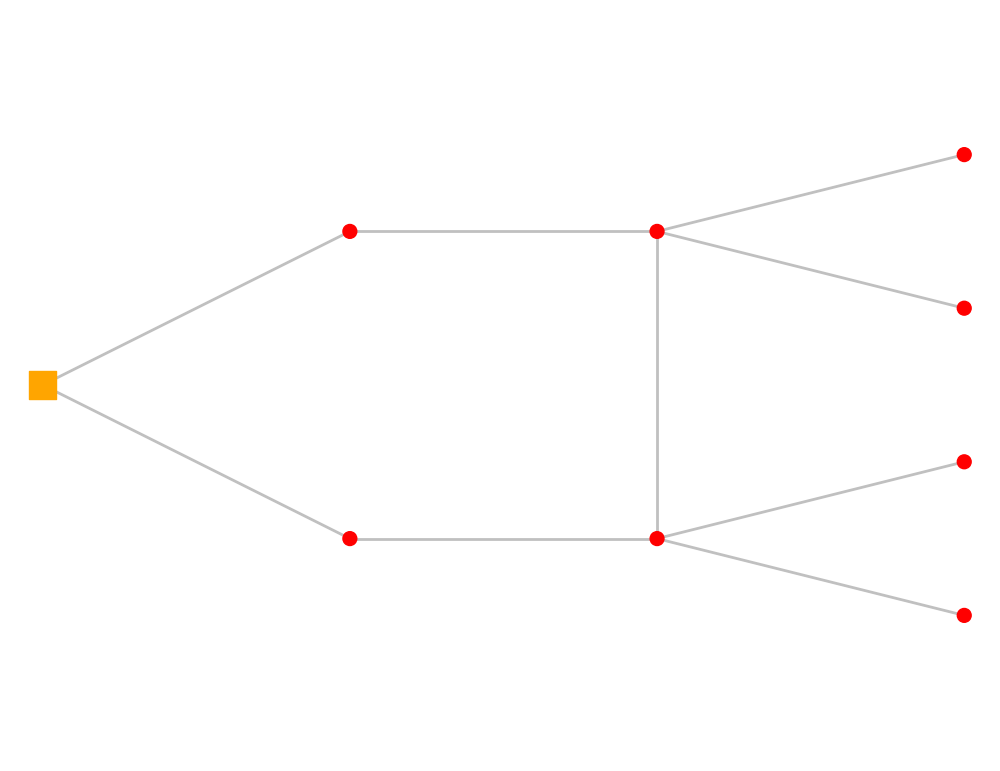

<Axes: >

In [76]:
pp_plot.simple_plot(net)

In [77]:
import plotly.express as px

junctions = net.res_junction.copy()
junctions["x"] = net.junction_geodata["x"]
junctions["y"] = net.junction_geodata["y"]

fig = px.scatter(
    junctions,
    x="x", y="y",
    color="p_bar",
    hover_data=["p_bar"],
    title="Junctions: Pressure and Temperature",
    labels={"p_bar": "Pressure [bar]"}
)
fig.show()

The above depiction is not displayed in the online documentation.

# Generating Pandapipes network using alternative_models() class from SIR 3S Toolkit

## Create

Now we can perform the same steps above confined into one method using [SIR_3S_to_pandapipes()](https://3sconsult.github.io/sir3stoolkit/references/sir3stoolkit.mantle.html#sir3stoolkit.mantle.alternative_models.Alternative_Models_SIR3S_Model.SIR_3S_to_pandapipes).

In [78]:
pp_net = s3s.SIR_3S_to_pandapipes()

[2025-10-07 13:27:30,428] INFO in sir3stoolkit.mantle.dataframes: [metadata] Generating metadata dataframe for element type: ObjectTypes.Node
[2025-10-07 13:27:30,429] INFO in sir3stoolkit.mantle.dataframes: [metadata] Retrieved 9 element(s) of element type ObjectTypes.Node.
[2025-10-07 13:27:30,430] DEBUG in sir3stoolkit.mantle.dataframes: [Resolving Metadata Properties] Using 5 metadata properties.
[2025-10-07 13:27:30,431] INFO in sir3stoolkit.mantle.dataframes: [metadata] Retrieving metadata properties ['Name', 'Zkor', 'QmEin', 'bz.PhEin', 'Ktyp'], geometry...
[2025-10-07 13:27:30,436] INFO in sir3stoolkit.mantle.dataframes: [metadata] 0 non-empty end node columns were created)
[2025-10-07 13:27:30,437] INFO in sir3stoolkit.mantle.dataframes: [metadata] Done. Shape: (9, 7)
[2025-10-07 13:27:30,483] INFO in sir3stoolkit.mantle.dataframes: [results] Generating results dataframe for element type: ObjectTypes.Node
[2025-10-07 13:27:30,501] INFO in sir3stoolkit.mantle.dataframes: [Resol

## Calculate

In [79]:
pp.pipeflow(net)

### View Results

In [80]:
net.res_junction

,p_bar,t_k
0,101.000000,273.15
1,100.932708,273.15
2,99.491364,273.15
3,97.843832,273.15
4,97.843832,273.15
5,100.289209,273.15
6,99.578419,273.15
7,99.501563,273.15
8,99.501563,273.15


In [81]:
net.res_pipe

,v_mean_m_per_s,p_from_bar,p_to_bar,t_from_k,t_to_k,t_outlet_k,mdot_from_kg_per_s,mdot_to_kg_per_s,vdot_m3_per_s,reynolds,lambda
0,0.587940,101.000000,100.932708,273.15,273.15,273.15,93.496673,-93.496673,0.093508,148220.775254,0.017522
1,2.037427,99.491364,97.843832,273.15,273.15,273.15,100.000000,-100.000000,0.100012,285354.955734,0.019847
2,2.037427,99.491364,97.843832,273.15,273.15,273.15,100.000000,-100.000000,0.100012,285354.955734,0.019847
3,1.927402,101.000000,100.289209,273.15,273.15,273.15,306.503327,-306.503327,0.306540,485901.348599,0.017222
4,1.927402,100.289209,99.578419,273.15,273.15,273.15,306.503327,-306.503327,0.306540,485901.348599,0.017222
5,0.628836,99.578419,99.501563,273.15,273.15,273.15,100.000000,-100.000000,0.100012,158530.530963,0.017494
6,0.628836,99.578419,99.501563,273.15,273.15,273.15,100.000000,-100.000000,0.100012,158530.530963,0.017494
7,1.904927,100.932708,99.491364,273.15,273.15,273.15,93.496673,-93.496673,0.093508,266797.395457,0.019862
8,-0.669731,99.491364,99.578419,273.15,273.15,273.15,-106.503327,106.503327,-0.106516,168840.286672,0.017470


In [82]:
net.res_sink

,mdot_kg_per_s
0,100.0
1,100.0
2,100.0
3,100.0


In [83]:
net.res_ext_grid

,mdot_kg_per_s
0,-400.0


## Plot

In [84]:
import plotly.express as px

junctions = net.res_junction.copy()
junctions["x"] = net.junction_geodata["x"]
junctions["y"] = net.junction_geodata["y"]

fig = px.scatter(
    junctions,
    x="x", y="y",
    color="p_bar",
    hover_data=["p_bar"],
    title="Junctions: Pressure and Temperature",
    labels={"p_bar": "Pressure [bar]"}
)
fig.show()

The above depiction is not displayed in the online documentation.